In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input, \
                                        BatchNormalization, Embedding, Masking,\
                                        Bidirectional, Conv1D, MaxPooling1D, Flatten, concatenate, MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import Model

from sklearn.utils import class_weight, shuffle
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.inspection import permutation_importance

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from xgboost import XGBRegressor, XGBClassifier
import lightgbm

import scipy.stats as stats
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")
BATCH_SIZE = 32
EPOCHS = 300

from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np
import cx_Oracle
import pandas as pd
from sqlalchemy import create_engine
from imblearn.over_sampling import SMOTE
from collections import Counter
import joblib
import shap

In [2]:
def generate_time(start_date:str, end_date:str, hour:int):
        start = datetime.strptime(start_date, '%d/%m/%Y')
        end = datetime.strptime(end_date, '%d/%m/%Y')

        dates = []
        while start<=end:
            row = [start]
            dates.append(row)
            start += timedelta(hours=hour)

        return pd.DataFrame(dates, columns=['TIMESTAMP'])
    
def query_status(eq_id):
    try:
        oracle_string = "oracle+cx_oracle://{username}:{password}@{hostname}:{port}/{database}"
        engine = create_engine(
            oracle_string.format(
                username = 'TFM4CEBERUS',
                password = 'TFM4CEBERUS',
                hostname = 'ome-db.bth.infineon.com',
                port = '1538',
                database = 'ome'
                )
            )
    except Exception as e:
        print(str(e))

    query = f"""select EQ_ID, TIMESTAMP_START, TIMESTAMP_END, DURATION, STATE_NAME, LEVEL3_NAME, LEVEL3 
            from (SELECT
              eq.eq_id, eq.name, eq.eq_type_ident
            , data.timestamp_start,data.timestamp_end
            , ROUND((data.timestamp_end - data.timestamp_start)*24*60*60,0) AS Duration
            , data.tr25_3_status,data.tr25_4_status,data.tr25_5_status,data.eq_status
            , level5s.state_name
            , level5.state_name Level5_Name, level5.state_sign Level5
            , level4.state_name Level4_Name, level4.state_sign Level4
            , level3.state_name Level3_Name, level3.state_sign Level3
            ,mh.device
            ,mh.package,
            mh.lotid as lot,
            mh.product,
            mh.operation

            FROM OMEDATA.EQUIPMENT_STATE_HISTORY data
            , OMEADMIN.EQUIPMENT_INSTANCES eq
            , V_EQ_STATES level5s
            , OMEADMIN.DEF_STANDARD_STATEMODEL level5
            , OMEADMIN.DEF_STANDARD_STATEMODEL level4
            , OMEADMIN.DEF_STANDARD_STATEMODEL level3
            , OMEDATA.METAKEY_HISTORY mh

            WHERE data.eq_ident  = eq.eq_ident
            AND  data.eq_status = level5s.state_ident(+)
            AND level5.state_ident = data.tr25_5_status
            AND level4.state_ident = data.tr25_4_status
            AND level3.state_ident = data.tr25_3_status
            AND  data.metakey_ident =mh.ident(+)
            and data.timestamp_start > sysdate - 1050)
            where eq_id = '{eq_id}'
            and TIMESTAMP_START <= to_date('30/9/2021', 'dd/mm/yyyy')
            ORDER BY TIMESTAMP_START"""

    status = pd.read_sql(query, engine)
    status.columns = map(lambda x: str(x).upper(), status.columns) 

    return status

def aggregate(timeframe_table, lookback_window, status_table):
    statename_df = pd.DataFrame(columns=status_table["STATE_NAME"].unique())

    for idx, row in timeframe_table.iterrows():
        end = row["TIMESTAMP"]
        start = end - timedelta(hours=lookback_window)

        ## count the frequencies of each statename, include everything since feature engineering would be performed
        filtered_statename = status_table.loc[(status_table["TIMESTAMP_START"] >= start) & 
                                              (status_table["TIMESTAMP_START"] <= end)]
        unique = filtered_statename["STATE_NAME"].unique()
        status_dict = {key:int(sum(filtered_statename.loc[filtered_statename.STATE_NAME==key]["DURATION"])) 
                       for key in unique}
        
        statename_df = statename_df.append(status_dict, ignore_index=True)
            
    statename_df = statename_df.fillna(0)
    cols = statename_df.columns
    statename_df[cols] = statename_df[cols].astype('int')
    return statename_df


def status_sequence(input_table, status_table, hour, scaled=False):
        status_seq = []
        duration_seq = []
        
        # validation check
        if status_table.iloc[0]["TIMESTAMP_START"] > input_table.iloc[0]["TIMESTAMP"]:
            raise Exception("Timeframe table must be a subset of the status table")
        if status_table.iloc[len(status_table)-1]["TIMESTAMP_START"] <= input_table.iloc[len(input_table)-1]["TIMESTAMP"]:
                raise Exception("Timeframe table must be a subset of the status table")
        
        for idx, row in input_table.iterrows():
            end = row["TIMESTAMP"]
            start = end - timedelta(hours=hour)
            
            condition = (status_table["TIMESTAMP_START"]>=start) & (status_table["TIMESTAMP_START"]<=end)

            table = status_table[condition]
            status_seq.append(table["STATE_NAME"].values)
            if scaled:
                duration_seq.append(table["SCALED_DURATION"].values)
            else:
                duration_seq.append(table["DURATION"].values)

        return status_seq, duration_seq


def major_down(input_df, status_table, hour, threshold): 
        hour = pd.Timedelta(hours=hour)
        major_down = []

        for idx, row in input_df.iterrows():
            start = row['TIMESTAMP']
            end = start+hour
            frame = status_table[(status_table['TIMESTAMP_START']>start) & (status_table['TIMESTAMP_START']<end)]
            UD = frame.loc[frame['LEVEL3']=='UDT']
            
            # disregard "waiting" in statename

            if len(UD) == 0: #no record within this 6 hours:
                major_down.append(0)
            else:
                time_diff = (UD['TIMESTAMP_END']-UD['TIMESTAMP_START']).dt.seconds
                if any(time_diff>=threshold): #threshold = 3600s
                    major_down.append(1)
                else:
                    major_down.append(0)
        return np.array(major_down)

def query_CAMSTAR(eq_id):
    try:
        oracle_string = "oracle+cx_oracle://{username}:{password}@{hostname}:{port}/{database}"
        engine = create_engine(
            oracle_string.format(
                username = 'bth_odsprod',
                password = 'bth_odsprodbth',
                hostname = 'odsprod-db.bth.infineon.com',
                port = '1523',
                database = 'odsprod'
                )
            )
    except Exception as e:
        print(str(e))

    query = f"""select EQUIPMENTNAME AS EQ_ID, TRACKINTIMESTAMP, TRACKOUTTIMESTAMP from A_WIPEQUIPMENTHISTORY t
                where t.equipmentname = '{eq_id}'
                ORDER BY TRACKINTIMESTAMP"""

    status = pd.read_sql(query, engine)

    return status

def label_encode(statename_seq): # do this the manual way as we are not certain if sklearn LabelEncoder can handle 3D array
    all_unique_statename = [set(ele) for ele in statename_seq]
    unique_statenames = set()
    for ele in all_unique_statename:
        unique_statenames |= ele
    
    enc_label = 1  #start encoding from 1 as we have to pad the sequence with 0
    mapping_dict = {}
    for ele in unique_statenames:
        mapping_dict[ele] = enc_label
        enc_label += 1

    enc_array = []
    #X_seq is a 3D array
    for timestamp in statename_seq:
        tmp_arr = []
        for ele in timestamp:
            tmp_arr.append(mapping_dict[ele])
        enc_array.append(np.array(tmp_arr))

    return np.array(enc_array), len(unique_statenames)+1, mapping_dict

In [3]:
# EDA for WBA124
wba124_status = query_status("WBA124")

In [4]:
##### Baseline model on uncleaned raw data #####

wba124_initial = wba124_status.copy()
hour = 24
threshold = 3600
beginning_major_down = []

for idx, row in wba124_initial.iterrows(): 
    start = row['TIMESTAMP_START']
    end = start+timedelta(hours=hour)
    frame = wba124_initial[(wba124_initial['TIMESTAMP_START']>start) & \
                                 (wba124_initial['TIMESTAMP_START']<end)]
    UD = frame.loc[frame['LEVEL3']=='UDT']

    if len(UD) == 0: #no record within this 6 hours:
        beginning_major_down.append(0)
    else:
        time_diff = (UD['TIMESTAMP_END']-UD['TIMESTAMP_START']).dt.seconds
        if any(time_diff>=threshold): #threshold = 3600s
            beginning_major_down.append(1)
        else:
            beginning_major_down.append(0)

In [5]:
wba124_initial["24 HOUR DOWN"] = beginning_major_down

In [6]:
##### Directly train on the raw data to test performance #####
not_feature = ['TIMESTAMP_START', 'TIMESTAMP_END', 'EQ_ID', 'LEVEL3_NAME', 'LEVEL3', 'STATE_NAME']

lb = LabelEncoder()
wba124_initial['ENC STATE NAME'] = lb.fit_transform(wba124_initial['STATE_NAME'])

tmp_table = wba124_initial.drop(not_feature, axis=1)

df = tmp_table[['DURATION', 'ENC STATE NAME']]
target = tmp_table['24 HOUR DOWN'].values

In [7]:
train_idx = int(0.7*len(df))
val_idx = int(0.8*(len(df)))

X_train, y_train = df[:train_idx], target[:train_idx]
X_val, y_val = df[train_idx:val_idx], target[train_idx:val_idx]
X_test, y_test = df[val_idx:], target[val_idx:]

clf = lightgbm.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    random_state=42,
    class_weight='balanced',
    reg_lambda=0.01
            )

clf.fit(X_train, y_train,
       eval_set=(X_val, y_val),
       eval_metric='f1',
        verbose=True)

pred = clf.predict(X_test)

confusion_matrix(y_test, pred), accuracy_score(y_test, pred)

[1]	valid_0's binary_logloss: 0.693596
[2]	valid_0's binary_logloss: 0.694275
[3]	valid_0's binary_logloss: 0.695009
[4]	valid_0's binary_logloss: 0.695883
[5]	valid_0's binary_logloss: 0.696706
[6]	valid_0's binary_logloss: 0.69753
[7]	valid_0's binary_logloss: 0.698223
[8]	valid_0's binary_logloss: 0.698899
[9]	valid_0's binary_logloss: 0.699796
[10]	valid_0's binary_logloss: 0.70043
[11]	valid_0's binary_logloss: 0.700943
[12]	valid_0's binary_logloss: 0.701548
[13]	valid_0's binary_logloss: 0.702188
[14]	valid_0's binary_logloss: 0.702639
[15]	valid_0's binary_logloss: 0.703207
[16]	valid_0's binary_logloss: 0.703643
[17]	valid_0's binary_logloss: 0.704065
[18]	valid_0's binary_logloss: 0.704517
[19]	valid_0's binary_logloss: 0.70495
[20]	valid_0's binary_logloss: 0.705268
[21]	valid_0's binary_logloss: 0.705547
[22]	valid_0's binary_logloss: 0.705767
[23]	valid_0's binary_logloss: 0.705853
[24]	valid_0's binary_logloss: 0.706056
[25]	valid_0's binary_logloss: 0.70627
[26]	valid_0'

(array([[6512, 7903],
        [4744, 7793]]),
 0.5307583852775304)

In [8]:
wba124_duration_sort = wba124_status.sort_values('DURATION', ascending=False).head(10)
wba124_sorted_duration_statename_val = wba124_duration_sort["STATE_NAME"].values
wba124_duration_sort

,EQ_ID,TIMESTAMP_START,TIMESTAMP_END,DURATION,STATE_NAME,LEVEL3_NAME,LEVEL3
9242,WBA124,2019-02-12 10:43:58,2019-09-25 17:31:57,19464479,PlanIdle,Standby (SB),SBY
80062,WBA124,2020-09-09 10:15:02,2021-04-22 08:15:36,19432834,IT Maintenance,Scheduled Down (SD),SDT
80617,WBA124,2020-09-13 23:48:02,2021-04-22 08:15:36,19038454,No Material,Standby (SB),SBY
90728,WBA124,2020-11-17 11:16:13,2021-04-22 08:15:36,13467563,No Material,Standby (SB),SBY
90795,WBA124,2020-11-18 10:19:36,2021-04-22 08:15:36,13384560,IT Maintenance,Scheduled Down (SD),SDT
18464,WBA124,2019-05-07 17:13:44,2019-09-25 17:31:57,12183493,Engineering PRE,Engineering (EN),ENG
105131,WBA124,2021-02-03 10:13:12,2021-04-22 08:15:36,6732144,IT Maintenance,Scheduled Down (SD),SDT
54440,WBA124,2020-02-05 09:50:12,2020-04-04 18:07:42,5127450,IT Maintenance,Scheduled Down (SD),SDT
65516,WBA124,2020-05-21 01:02:53,2020-06-03 03:44:48,1132915,Non Schedule Time,Non-scheduled time (NS),NST
127649,WBA124,2021-07-31 13:52:55,2021-08-10 08:10:16,843441,NoWIP,Standby (SB),SBY


In [59]:
wba124_status.iloc[9239:9250]

,EQ_ID,TIMESTAMP_START,TIMESTAMP_END,DURATION,STATE_NAME,LEVEL3_NAME,LEVEL3
9239,WBA124,2019-02-11 21:50:06,2019-02-12 10:42:04,46318,Engineering PRE,Engineering (EN),ENG
9240,WBA124,2019-02-12 10:42:04,2019-02-12 10:43:58,114,PlanIdle,Standby (SB),SBY
9241,WBA124,2019-02-12 10:43:58,2019-09-25 17:31:57,19464479,PlanIdle,Standby (SB),SBY
9242,WBA124,2019-02-13 00:40:01,2019-02-13 00:40:19,18,Normal Production,Productive (PR),PRD
9243,WBA124,2019-02-13 00:40:19,2019-02-13 00:40:29,10,Waiting For Operator,Unscheduled Down (UD),UDT
9244,WBA124,2019-02-13 00:40:29,2019-02-13 00:40:37,8,Normal Production,Productive (PR),PRD
9245,WBA124,2019-02-13 00:40:37,2019-02-13 00:42:22,105,Non LIFTED STICK BOND,Unscheduled Down (UD),UDT
9246,WBA124,2019-02-13 00:42:22,2019-02-13 00:42:28,6,Normal Production,Productive (PR),PRD
9247,WBA124,2019-02-13 00:42:28,2019-02-13 00:42:42,14,Waiting For Operator,Unscheduled Down (UD),UDT
9248,WBA124,2019-02-13 00:42:42,2019-02-13 00:43:04,22,Normal Production,Productive (PR),PRD


In [9]:
# check these rows, how many transactions are in the middle
for idx in wba124_duration_sort.index:
    start = wba124_status.iloc[idx]["TIMESTAMP_START"]
    end = wba124_status.iloc[idx]["TIMESTAMP_END"]
    filtered = wba124_status.loc[(wba124_status.TIMESTAMP_START>=start) & 
                                (wba124_status.TIMESTAMP_START<end)]
    print(f'In between timestamp of row {idx}, there are {len(filtered)-1} transactions')
    
# for status with other transaction in the middle, should they be invalid

In between timestamp of row 9242, there are 22632 transactions
In between timestamp of row 80062, there are 35427 transactions
In between timestamp of row 80617, there are 34872 transactions
In between timestamp of row 90728, there are 24761 transactions
In between timestamp of row 90795, there are 24694 transactions
In between timestamp of row 18464, there are 13410 transactions
In between timestamp of row 105131, there are 10358 transactions
In between timestamp of row 54440, there are 8015 transactions
In between timestamp of row 65516, there are 0 transactions
In between timestamp of row 127649, there are 0 transactions


In [10]:
# notice how 2021-04-22 has the longest duration, for WBA127 & WBA124 likely for other machines as well
# someone closed all the status on this day
# remove these data points

apr = datetime(2021,4,22)
end = apr + timedelta(days=1)
wba124_status[(wba124_status["TIMESTAMP_END"]>=apr)&
               (wba124_status["TIMESTAMP_END"]<=end)].sort_values('DURATION', ascending=False).head(10)

,EQ_ID,TIMESTAMP_START,TIMESTAMP_END,DURATION,STATE_NAME,LEVEL3_NAME,LEVEL3
80062,WBA124,2020-09-09 10:15:02,2021-04-22 08:15:36,19432834,IT Maintenance,Scheduled Down (SD),SDT
80617,WBA124,2020-09-13 23:48:02,2021-04-22 08:15:36,19038454,No Material,Standby (SB),SBY
90728,WBA124,2020-11-17 11:16:13,2021-04-22 08:15:36,13467563,No Material,Standby (SB),SBY
90795,WBA124,2020-11-18 10:19:36,2021-04-22 08:15:36,13384560,IT Maintenance,Scheduled Down (SD),SDT
105131,WBA124,2021-02-03 10:13:12,2021-04-22 08:15:36,6732144,IT Maintenance,Scheduled Down (SD),SDT
115490,WBA124,2021-04-22 09:06:27,2021-04-22 12:22:17,11750,Waiting for Setup,Unscheduled Down (UD),UDT
115576,WBA124,2021-04-22 17:28:05,2021-04-22 20:07:35,9570,PC Buyoff,Scheduled Down (SD),SDT
115494,WBA124,2021-04-22 12:54:03,2021-04-22 13:57:30,3807,Waiting for Setup,Unscheduled Down (UD),UDT
115575,WBA124,2021-04-22 16:27:08,2021-04-22 17:28:05,3657,Waiting for Setup,Unscheduled Down (UD),UDT
115617,WBA124,2021-04-22 22:55:58,2021-04-22 23:46:52,3054,Waiting For Repair,Unscheduled Down (UD),UDT


In [11]:
# check for 0 duration
wba124_duration_sort_asc = wba124_status.sort_values('DURATION')
zero_seconds = wba124_status.loc[wba124_status.DURATION==0.0]
print(f'There are {len(zero_seconds)} rows with 0.0 seconds as DURATION')
print(f'Distribution of LEVEL3:\n{zero_seconds["LEVEL3"].value_counts()}')
wba124_duration_sort_asc.head(10)

There are 826 rows with 0.0 seconds as DURATION
Distribution of LEVEL3:
UDT    305
SDT    223
PRD    165
SBY    122
EXC     10
NST      1
Name: LEVEL3, dtype: int64


,EQ_ID,TIMESTAMP_START,TIMESTAMP_END,DURATION,STATE_NAME,LEVEL3_NAME,LEVEL3
5003,WBA124,2019-01-06 16:23:43,2019-01-06 16:23:41,-2,Waiting For Response,Standby (SB),SBY
24784,WBA124,2019-07-14 23:41:08,2019-07-14 23:41:08,0,Normal Production,Productive (PR),PRD
2805,WBA124,2018-12-21 06:06:39,2018-12-21 06:06:39,0,NO BONDING,Unscheduled Down (UD),UDT
13555,WBA124,2019-03-13 11:03:24,2019-03-13 11:03:24,0,Normal Production,Productive (PR),PRD
9637,WBA124,2019-02-17 08:43:55,2019-02-17 08:43:55,0,Change Capillary,Scheduled Down (SD),SDT
13538,WBA124,2019-03-13 08:41:24,2019-03-13 08:41:24,0,Change Capillary,Scheduled Down (SD),SDT
27795,WBA124,2019-08-19 16:13:32,2019-08-19 16:13:32,0,Change Device,Scheduled Down (SD),SDT
96964,WBA124,2020-12-15 23:41:35,2020-12-15 23:41:35,0,Normal Production,Productive (PR),PRD
70569,WBA124,2020-06-26 00:58:59,2020-06-26 00:58:59,0,Waiting For Response,Standby (SB),SBY
9644,WBA124,2019-02-17 09:14:10,2019-02-17 09:14:10,0,NO BONDING,Unscheduled Down (UD),UDT


In [12]:
# Remove one row of negative DURATION 
check_duration = wba124_status.loc[wba124_status.DURATION<0.0]
print(len(check_duration))
wba124_status = wba124_status.drop(index=check_duration.index, axis=0)
check_duration1 = wba124_status.loc[wba124_status.DURATION<0.0]
len(check_duration1) == 0

1


True

In [13]:
wba124_status = wba124_status.reset_index(drop=True) # always reset index after you drop
wba124_clean_status = wba124_status.copy()

In [14]:
# also find out rows with the same state name and is split into 2
# remove first -> reset index and check for rows with same state name again
# because removing will bring some rows up and they will now have the same state name as the previous one

idx_row = []
same_state_idx = []
for idx, row in wba124_clean_status.iterrows():
    if idx == len(wba124_clean_status)-1:
        break
    end = row["TIMESTAMP_END"]
    state1 = row["STATE_NAME"]
    next_row = wba124_clean_status.iloc[idx+1]
    next_start = next_row["TIMESTAMP_START"]
    state2 = next_row["STATE_NAME"]
    
    # timestamp end of this row later than timestamp_start of next row
    if end > next_start:
        idx_row.append(idx)
        
    # same state name but broken into 2 records
    if end == next_start and state1 == state2:
        same_state_idx.append(idx)
    
print(f'Rows with overlapping transaction {idx_row}')
print(f'There are {len(same_state_idx)} rows with the same state name as the next row with the same timestamp')

Rows with overlapping transaction [1756, 2734, 4940, 5001, 5387, 5579, 5596, 5644, 5647, 5759, 5866, 5874, 5884, 5896, 5901, 5942, 6306, 6446, 6451, 6471, 6947, 7936, 8266, 8966, 9086, 9133, 9241, 9290, 9627, 9863, 10512, 11512, 12247, 12401, 12406, 12595, 13388, 13553, 13768, 14193, 14201, 14724, 14941, 16060, 16153, 16273, 16342, 17040, 17131, 17543, 17795, 18448, 18463, 18786, 18985, 19990, 20029, 20874, 21444, 22843, 23030, 23164, 23176, 23963, 24088, 24556, 24562, 24689, 25156, 25903, 26667, 27279, 27340, 27413, 27442, 27510, 27793, 27845, 27978, 29232, 29352, 29382, 29555, 29627, 29631, 29635, 29637, 30317, 30986, 31049, 31235, 31936, 32002, 32732, 33409, 33647, 33674, 33746, 35028, 37801, 38552, 38597, 39892, 41621, 41659, 42143, 42145, 42567, 42681, 43756, 43840, 44119, 44381, 44864, 45587, 46398, 46810, 49961, 49976, 50036, 50514, 51119, 52066, 53547, 53810, 54439, 54440, 54967, 55181, 56367, 56669, 60842, 61173, 61832, 62557, 63223, 63592, 64923, 65798, 66422, 66521, 66547, 6

In [15]:
# 1. Remove duration = 0
len1 = len(wba124_clean_status)
wba124_clean_status = wba124_clean_status[~(wba124_clean_status.DURATION==0.0)]
len2 = len(wba124_clean_status)
print(f'Removed {len1-len2} rows of data with duration as 0.0')

Removed 826 rows of data with duration as 0.0


In [16]:
# 2. Remove the 9 rows with long duration

len3 = len(wba124_clean_status)
wba124_clean_status = wba124_clean_status.drop(index=idx_row, axis=0)
len4 = len(wba124_clean_status)
print(f'Removed {len3-len4} rows of data with long duration (overlapping timestamp start and end)')

Removed 194 rows of data with long duration (overlapping timestamp start and end)


In [17]:
# apparently status can be uncontinuous, there might be some transaction in between timestamp of each row
# find rows which the timestamp end is later than the next timestamp start
# to prove all those with status in the middle are recorded wrongly

# 3. Check again and make sure no overlapping timestamp (all timestamp_start must be >= last timestamp_end)
idx_rows_check = []
same_state_check = []
wba124_clean_status = wba124_clean_status.reset_index(drop=True)
for idx, row in wba124_clean_status.iterrows():
    
    if idx == len(wba124_clean_status)-1:
        break
    end = row["TIMESTAMP_END"]
    state1 = row["STATE_NAME"]
    next_row = wba124_clean_status.iloc[idx+1]
    next_start = next_row["TIMESTAMP_START"]
    state2 = next_row["STATE_NAME"]
    
    if end > next_start:
        idx_rows_check.append(idx)
    if end == next_start and state1 == state2:
        same_state_check.append(idx)
    
print(f'Rows with overlapping transaction {idx_rows_check}')
print(f'There are {len(same_state_check)} rows with the same state name as the next row with the same timestamp')

Rows with overlapping transaction []
There are 2983 rows with the same state name as the next row with the same timestamp


In [18]:
# clean up status data 
# (do not remove special level3 as sometimes engineers would run dummy lot and CAMSTAR will not have record but TFM has)

# 4. combine timestamp_end == next row timestamp_start, start from the back as there are some with continuous rows
for idx in reversed(same_state_check):
    duration = sum(wba124_clean_status.iloc[idx:idx+2]["DURATION"])
    wba124_clean_status.at[idx, 'DURATION'] = duration
    wba124_clean_status.at[idx, 'TIMESTAMP_END'] = wba124_clean_status.iloc[idx+1]["TIMESTAMP_END"]
    wba124_clean_status.drop(index=idx+1, axis=0, inplace=True)

# validate all timestamp_end == timestamp start with same state name datapoints have been combined
idx_rows = []
same_state = []
wba124_clean_status = wba124_clean_status.reset_index(drop=True)
for idx, row in wba124_clean_status.iterrows():
    if idx == len(wba124_clean_status)-1:
        break
    end = row["TIMESTAMP_END"]
    state1 = row["STATE_NAME"]
    next_row = wba124_clean_status.iloc[idx+1]
    next_start = next_row["TIMESTAMP_START"]
    state2 = next_row["STATE_NAME"]
    
    if end > next_start:
        idx_rows.append(idx)
    if end == next_start and state1 == state2:
        same_state.append(idx)
    
print(f'Rows with overlapping transaction {idx_rows}')
print(f'There are {len(same_state)} rows with the same state name as the next row with the same timestamp')

Rows with overlapping transaction []
There are 0 rows with the same state name as the next row with the same timestamp


In [19]:
print(f'Removed a total of {len(wba124_status)-len(wba124_clean_status)} rows from {len(wba124_status)}.')

wba124_clean_status = wba124_clean_status.sort_values('TIMESTAMP_START', ascending=True) # rearrange just in case

Removed a total of 4003 rows from 134758.


In [20]:
store wba124_clean_status

Stored 'wba124_clean_status' (DataFrame)


In [21]:
# compute major down and check the relationship between alarms using histogram (split into class 0 and class 1)
wba124_timeframe_table = generate_time('5/12/2018', '31/8/2021', 24)
wba124_major_down_arr = major_down(wba124_timeframe_table, wba124_clean_status, 24, 3600)
wba124_timeframe_table["MAJOR DOWN"] = wba124_major_down_arr

In [22]:
# major down validation check, just make sure at least one row will show here
timestamp_check = wba124_timeframe_table[wba124_timeframe_table["MAJOR DOWN"]==1].iloc[250]["TIMESTAMP"]
print(timestamp_check)
timestampend_check = timestamp_check + timedelta(hours=24)
filtered = wba124_clean_status[(wba124_clean_status["TIMESTAMP_START"]>=timestamp_check) &
             (wba124_clean_status["TIMESTAMP_START"]<=timestampend_check)]
filtered.loc[(filtered.LEVEL3 == "UDT") & (filtered.DURATION >= 3600)]

2021-03-22 00:00:00


,EQ_ID,TIMESTAMP_START,TIMESTAMP_END,DURATION,STATE_NAME,LEVEL3_NAME,LEVEL3
107675,WBA124,2021-03-22 22:46:20,2021-03-22 23:49:44,3804,Non LIFTED STICK BOND,Unscheduled Down (UD),UDT


In [23]:
# plot histogram to see relationship between state name and major down
statename_seq, duration_seq = status_sequence(wba124_timeframe_table, wba124_clean_status, 24)

wba124_timeframe_table["STATENAME SEQ"] = statename_seq
wba124_timeframe_table["DURATION SEQ"] = duration_seq

positive = wba124_timeframe_table.loc[wba124_timeframe_table["MAJOR DOWN"]==1]
negative = wba124_timeframe_table.loc[wba124_timeframe_table["MAJOR DOWN"]==0]

statename_pos = positive["STATENAME SEQ"].values
statename_neg = negative["STATENAME SEQ"].values
duration_pos = positive["DURATION SEQ"].values
duration_neg = negative["DURATION SEQ"].values

pos = []
dur_pos = []
neg = []
dur_neg = []
for state_p, dur_p in zip(statename_pos, duration_pos):
    pos.extend(state_p)
    dur_pos.extend(dur_p)

for state_n, dur_n in zip(statename_neg, duration_neg):
    neg.extend(state_n)
    dur_neg.extend(dur_n)

In [24]:
# data validation check
print("negative length = ", len(neg))
print("positive length = ", len(pos))
print(f'Total number of data collected = {len(neg) + len(pos)}') 

# the 3 extra collections is because 3 rows of data in clean_status just so happen to start at midnight
aaa = wba124_timeframe_table.iloc[0]["TIMESTAMP"] - timedelta(hours=24)
bbb = wba124_timeframe_table.iloc[len(wba124_timeframe_table)-1]["TIMESTAMP"]
ccc = wba124_clean_status[(wba124_clean_status["TIMESTAMP_START"]>=aaa) & (wba124_clean_status["TIMESTAMP_START"]<=bbb)]
timestamps = wba124_timeframe_table["TIMESTAMP"].values
print(f'Total length of clean status table = {len(ccc)}')
wba124_clean_status[wba124_clean_status["TIMESTAMP_START"].isin(timestamps)]

negative length =  83107
positive length =  43166
Total number of data collected = 126273
Total length of clean status table = 126265


,EQ_ID,TIMESTAMP_START,TIMESTAMP_END,DURATION,STATE_NAME,LEVEL3_NAME,LEVEL3
43935,WBA124,2019-12-20,2019-12-20 00:06:04,364,Normal Production,Productive (PR),PRD
59891,WBA124,2020-04-01,2020-04-01 00:00:34,34,Waiting For Response,Standby (SB),SBY
61690,WBA124,2020-04-27,2020-04-27 00:00:20,20,Normal Production,Productive (PR),PRD
76799,WBA124,2020-09-06,2020-09-06 00:01:14,74,Normal Production,Productive (PR),PRD
85457,WBA124,2020-11-02,2020-11-02 00:14:52,892,Waiting For Repair,Unscheduled Down (UD),UDT
93524,WBA124,2020-12-13,2020-12-13 00:00:03,3,Normal Production,Productive (PR),PRD
98313,WBA124,2021-01-11,2021-01-11 00:00:05,5,Normal Production,Productive (PR),PRD
103566,WBA124,2021-02-15,2021-02-15 00:14:09,849,Normal Production,Productive (PR),PRD


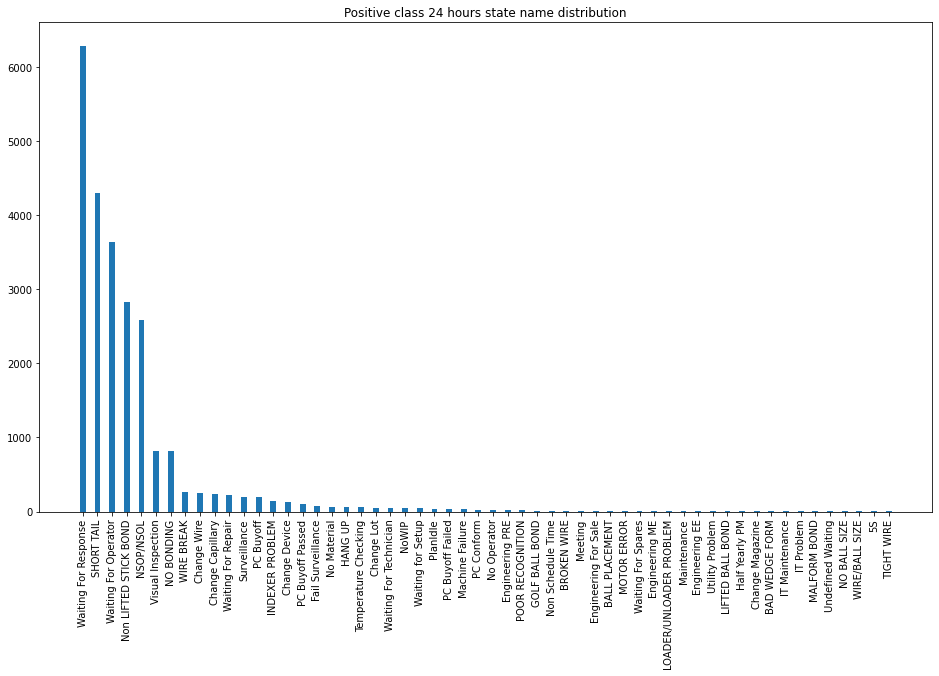

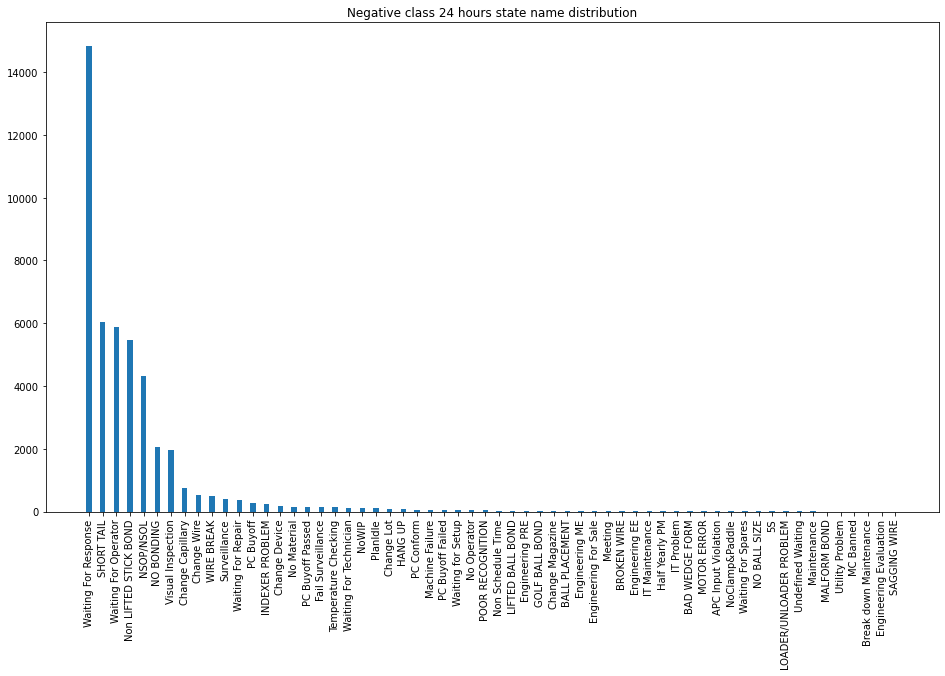

In [25]:
# notice that the top few state name frequencies are very similar for both machines
count_helper = Counter(pos)
NP_pos_count = count_helper.pop('Normal Production') # remove normal production to or else cannot visualize the graph

pos_sort_count = {}
for key, val in sorted(count_helper.items(), key=lambda x: x[1], reverse=True):
    if key is not None: # putting in 'Exception' LEVEL3 will cause matplotlib error
        pos_sort_count[key] = val

plt.figure(figsize=(16,9))
plt.bar(pos_sort_count.keys(), pos_sort_count.values(), width=0.4)
plt.title("Positive class 24 hours state name distribution")
plt.xticks(rotation=90)
plt.show()

neg_count_helper = Counter(neg)

NP_neg_count = neg_count_helper.pop('Normal Production') # remove normal production to or else cannot visualize the graph
Level3_Exception_count = neg_count_helper.pop(None) # Exception all happen during positive class

neg_sort_count = {}
for key, val in sorted(neg_count_helper.items(), key=lambda x: x[1], reverse=True):
    if key is not None:
        neg_sort_count[key] = val

plt.figure(figsize=(16,9))
plt.bar(neg_sort_count.keys(), neg_sort_count.values(), width=0.4)
plt.title("Negative class 24 hours state name distribution")
plt.xticks(rotation=90)
plt.show()

In [26]:
# remove rare occurence item, probably not helpful
print('State name that only appears in positive class = \n',
      [[ele, val] for ele, val in pos_sort_count.items() if ele not in neg_sort_count.keys()])
print('\nOnly in negative class = \n', [[ele, val] for ele, val in neg_sort_count.items() if ele not in pos_sort_count.keys()])

# check on other equipment as well, keep rare STATE_NAME

State name that only appears in positive class = 
 [['WIRE/BALL SIZE', 1], ['TIGHT WIRE', 1]]

Only in negative class = 
 [['APC Input Violation', 4], ['NoClamp&Paddle', 3], ['MC Banned', 1], ['Break down Maintenance', 1], ['Engineering Evaluation', 1], ['SAGGING WIRE', 1]]


<AxesSubplot:xlabel='TIMESTAMP_START'>

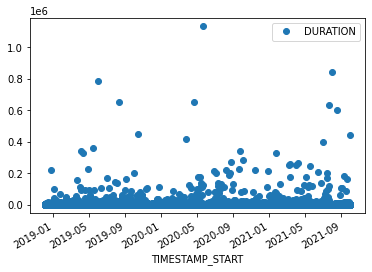

In [27]:
# check for DURATION outliers
# still about 5 spots standing out, investigate
wba124_clean_status.plot(x='TIMESTAMP_START', y='DURATION', marker='o', linestyle='none')

In [28]:
outlier_dur = wba124_clean_status.sort_values('DURATION', ascending=False).head(5)
outlier_dur

,EQ_ID,TIMESTAMP_START,TIMESTAMP_END,DURATION,STATE_NAME,LEVEL3_NAME,LEVEL3
62982,WBA124,2020-05-21 01:02:53,2020-06-03 03:45:11,1132938,Non Schedule Time,Non-scheduled time (NS),NST
123823,WBA124,2021-07-31 13:52:55,2021-08-10 08:10:16,843441,NoWIP,Standby (SB),SBY
20019,WBA124,2019-05-30 05:13:52,2019-06-08 08:19:25,788733,Non Schedule Time,Non-scheduled time (NS),NST
61622,WBA124,2020-04-18 21:17:08,2020-04-26 10:12:36,651328,NoWIP,Standby (SB),SBY
26364,WBA124,2019-08-11 01:13:15,2019-08-18 13:46:54,650019,Non Schedule Time,Non-scheduled time (NS),NST


In [29]:
# check if there is any major down 24 hours after these values
check_date = outlier_dur.iloc[0]['TIMESTAMP_END']
end = check_date + timedelta(hours=24)
wba124_clean_status[(wba124_clean_status['TIMESTAMP_START']>=check_date) &
                   (wba124_clean_status['TIMESTAMP_START']<=end) &
                   (wba124_clean_status['LEVEL3'] == 'UDT') &
                   (wba124_clean_status['DURATION']>=3600)]

# found out that for majority of the time, give long duration, high chance a major down would occur within 24 hours
# keep the outliers

,EQ_ID,TIMESTAMP_START,TIMESTAMP_END,DURATION,STATE_NAME,LEVEL3_NAME,LEVEL3
63033,WBA124,2020-06-03 06:22:31,2020-06-03 07:28:39,3968,Non LIFTED STICK BOND,Unscheduled Down (UD),UDT


In [30]:
##### collect major down at each row #####
hour = 24
threshold = 3600
lookback_window = 30

# take out the last 2 days in order to collect major down correctly
last_date = wba124_clean_status.iloc[len(wba124_clean_status)-1]["TIMESTAMP_START"]
two_days = last_date - timedelta(days=2)
walk_forward_dataset = wba124_clean_status[wba124_clean_status["TIMESTAMP_START"]<two_days].reset_index(drop=True)

major_down = []
for idx, row in walk_forward_dataset.iterrows(): 
    start = row['TIMESTAMP_START']
    end = start+timedelta(hours=hour)
    frame = wba124_clean_status[(wba124_clean_status['TIMESTAMP_START']>start) & \
                                 (wba124_clean_status['TIMESTAMP_START']<end)]
    UD = frame.loc[frame['LEVEL3']=='UDT']

    if len(UD) == 0: #no record within this 6 hours:
        major_down.append(0)
    else:
        time_diff = (UD['TIMESTAMP_END']-UD['TIMESTAMP_START']).dt.seconds
        if any(time_diff>=threshold): #threshold = 3600s
            major_down.append(1)
        else:
            major_down.append(0)
    
walk_forward_dataset["24 HOUR DOWN"] = major_down

In [57]:
walk_forward_dataset[['STATE_NAME', 'DURATION', '24 HOUR DOWN']]

,STATE_NAME,DURATION,24 HOUR DOWN
0,Waiting For Response,135,0
1,Normal Production,2570,0
2,Waiting For Response,72,0
3,NO BONDING,2,0
4,Normal Production,434,0
...,...,...,...
130191,Non LIFTED STICK BOND,144,1
130192,Waiting For Response,28,1
130193,Normal Production,3,1
130194,Non LIFTED STICK BOND,11,1


In [32]:
##### Baseline model 2 on cleaned removed data #####

not_feature = ['TIMESTAMP_START', 'TIMESTAMP_END', 'EQ_ID', 'LEVEL3_NAME', 'LEVEL3', 'STATE_NAME']

lb = LabelEncoder()
walk_forward_dataset['ENC STATE NAME'] = lb.fit_transform(walk_forward_dataset['STATE_NAME'])

tmp_table = walk_forward_dataset.drop(not_feature, axis=1)

df = tmp_table[['DURATION', 'ENC STATE NAME']]
target = tmp_table['24 HOUR DOWN'].values

In [33]:
train_idx = int(0.7*len(df))
val_idx = int(0.8*(len(df)))

X_train, y_train = df[:train_idx], target[:train_idx]
X_val, y_val = df[train_idx:val_idx], target[train_idx:val_idx]
X_test, y_test = df[val_idx:], target[val_idx:]

clf = lightgbm.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    random_state=42,
    class_weight='balanced',
    reg_lambda=0.01
            )

clf.fit(X_train, y_train,
       eval_set=(X_val, y_val),
       eval_metric='auc',
        verbose=True)

pred = clf.predict(X_test)

confusion_matrix(y_test, pred), accuracy_score(y_test, pred)

[1]	valid_0's auc: 0.498338	valid_0's binary_logloss: 0.693585
[2]	valid_0's auc: 0.499788	valid_0's binary_logloss: 0.694208
[3]	valid_0's auc: 0.499234	valid_0's binary_logloss: 0.695016
[4]	valid_0's auc: 0.499382	valid_0's binary_logloss: 0.695744
[5]	valid_0's auc: 0.498971	valid_0's binary_logloss: 0.696597
[6]	valid_0's auc: 0.499327	valid_0's binary_logloss: 0.697508
[7]	valid_0's auc: 0.501322	valid_0's binary_logloss: 0.698231
[8]	valid_0's auc: 0.501391	valid_0's binary_logloss: 0.699006
[9]	valid_0's auc: 0.501572	valid_0's binary_logloss: 0.699713
[10]	valid_0's auc: 0.50204	valid_0's binary_logloss: 0.700291
[11]	valid_0's auc: 0.502332	valid_0's binary_logloss: 0.700844
[12]	valid_0's auc: 0.502503	valid_0's binary_logloss: 0.701408
[13]	valid_0's auc: 0.502942	valid_0's binary_logloss: 0.701768
[14]	valid_0's auc: 0.503051	valid_0's binary_logloss: 0.702382
[15]	valid_0's auc: 0.503625	valid_0's binary_logloss: 0.702776
[16]	valid_0's auc: 0.503409	valid_0's binary_logl

(array([[6396, 7958],
        [4122, 7564]]),
 0.5360983102918587)

In [34]:
##### TIME SINCE FAILURE #####
major_down_idx = walk_forward_dataset[(walk_forward_dataset["LEVEL3"]=='UDT') &
                                     (walk_forward_dataset["DURATION"] >= 3600)].index.to_list()

# there are 515 transaction of major down
tsf =[]
tsf_df = walk_forward_dataset.iloc[major_down_idx[0]:major_down_idx[-1]+1]
count = 0

for idx, row in tsf_df.iterrows():
    if idx in major_down_idx:
        count = major_down_idx.index(idx)
        tsf.append(0)
        continue
        
    last_down_time = tsf_df.iloc[count]["TIMESTAMP_END"]
    curr_time = row["TIMESTAMP_START"]
    diff = (curr_time - last_down_time).seconds
    tsf.append(diff)
tsf_df["TIME SINCE FAILURE"] = tsf

<AxesSubplot:>

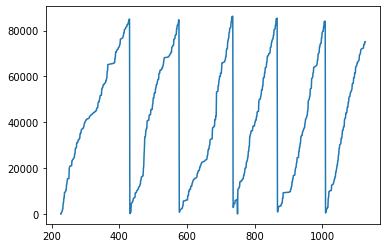

In [35]:
tsf_df['TIME SINCE FAILURE'][:900].plot()

In [36]:
lb = LabelEncoder()
enc_state = lb.fit_transform(tsf_df['STATE_NAME'])
tsf_df['ENC STATE NAME'] = enc_state

In [37]:
##### Lag DURATION and STATE NAME feature #####
lags = [1,2,3,4,5]
for lag in lags:
    tsf_df[f'DURATION LAGGED {lag}'] = tsf_df['DURATION'].shift(lag)
    tsf_df[f'ENC STATE NAME LAGGED {lag}'] = tsf_df['ENC STATE NAME'].shift(lag)

In [38]:
##### Rolling aggregation of DURATION and TIME SINCE FAILURE #####
rolling = [5, 10, 15, 20]
for roll in rolling:
    tsf_df[f'DURATION ROLL {roll}'] = tsf_df['DURATION'].rolling(roll).mean()
    tsf_df[f'TSF ROLL {roll}'] = tsf_df['TIME SINCE FAILURE'].rolling(roll).mean()

In [39]:
##### calculate number of occurrence of each state name within this day #####
tsf_df = tsf_df.dropna(axis=0)

tsf_df['DATE'] = tsf_df['TIMESTAMP_START'].dt.date
tsf_df['DAY'] = tsf_df['TIMESTAMP_START'].dt.day
tsf_df['WEEK'] = tsf_df['TIMESTAMP_START'].dt.isocalendar()['week']
tsf_df['MONTH'] = tsf_df['TIMESTAMP_START'].dt.month
tsf_df['YEAR'] = tsf_df['TIMESTAMP_START'].dt.isocalendar()['year']

day_gb = tsf_df.groupby(['DATE', 'STATE_NAME']).count()['EQ_ID']
week_gb = tsf_df.groupby(['YEAR', 'WEEK', 'STATE_NAME']).count()['EQ_ID']
month_gb = tsf_df.groupby(['YEAR', 'MONTH', 'STATE_NAME']).count()['EQ_ID']

freq_day = []
freq_week = []
freq_month = []

for idx, row in tsf_df.iterrows():
    state_name = row['STATE_NAME']
    date = row['DATE']
    week = row['WEEK']
    month = row['MONTH']
    year = row['YEAR']
    
    FREQ_DAY = day_gb.iloc[(day_gb.index.get_level_values('STATE_NAME')==state_name) & 
                        (day_gb.index.get_level_values('DATE')==date)].values[0]
    
    FREQ_WEEK = week_gb.iloc[(week_gb.index.get_level_values('STATE_NAME')==state_name) & 
                         (week_gb.index.get_level_values('YEAR')==year) &
                         (week_gb.index.get_level_values('WEEK')==week)].values[0]
    
    FREQ_MONTH = month_gb.iloc[(month_gb.index.get_level_values('STATE_NAME')==state_name) & 
                          (month_gb.index.get_level_values('YEAR')==year) &
                          (month_gb.index.get_level_values('MONTH')==month)].values[0]
    
    freq_day.append(FREQ_DAY)
    freq_week.append(FREQ_WEEK)
    freq_month.append(FREQ_MONTH)

tsf_df['FREQ DAY'] = freq_day
tsf_df['FREQ WEEK'] = freq_week
tsf_df['FREQ MONTH'] = freq_month

In [40]:
tsf_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129753 entries, 246 to 130001
Data columns (total 36 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   EQ_ID                    129753 non-null  object        
 1   TIMESTAMP_START          129753 non-null  datetime64[ns]
 2   TIMESTAMP_END            129753 non-null  datetime64[ns]
 3   DURATION                 129753 non-null  int64         
 4   STATE_NAME               129753 non-null  object        
 5   LEVEL3_NAME              129753 non-null  object        
 6   LEVEL3                   129753 non-null  object        
 7   24 HOUR DOWN             129753 non-null  int64         
 8   ENC STATE NAME           129753 non-null  int64         
 9   TIME SINCE FAILURE       129753 non-null  int64         
 10  DURATION LAGGED 1        129753 non-null  float64       
 11  ENC STATE NAME LAGGED 1  129753 non-null  float64       
 12  DURATION LAGGE

In [41]:
not_features = ['DATE','TIMESTAMP_START', 'TIMESTAMP_END', 'EQ_ID',
               'LEVEL3_NAME', 'LEVEL3', 'STATE_NAME', 'DATE', '24 HOUR DOWN',
               'DATE', 'YEAR', 'MONTH', 'WEEK', 'DAY',
               'FREQ DAY', 'FREQ WEEK', 'FREQ MONTH']

df = tsf_df.drop(not_features, axis=1)
target = tsf_df['24 HOUR DOWN']

In [42]:
train_idx = int(0.7*len(df))
val_idx = int(0.8*(len(df)))

X_train, y_train = df[:train_idx], target[:train_idx]
X_val, y_val = df[train_idx:val_idx], target[train_idx:val_idx]
X_test, y_test = df[val_idx:], target[val_idx:]

clf = lightgbm.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    random_state=42,
    learning_rate=0.05,
    class_weight='balanced',
    reg_lambda=0.01
            )

clf.fit(X_train, y_train,
       eval_set=(X_val, y_val),
       eval_metric='AUC',
        verbose=True)

[1]	valid_0's auc: 0.505245	valid_0's binary_logloss: 0.693611
[2]	valid_0's auc: 0.505353	valid_0's binary_logloss: 0.694137
[3]	valid_0's auc: 0.504681	valid_0's binary_logloss: 0.694784
[4]	valid_0's auc: 0.500132	valid_0's binary_logloss: 0.695588
[5]	valid_0's auc: 0.499241	valid_0's binary_logloss: 0.696258
[6]	valid_0's auc: 0.498585	valid_0's binary_logloss: 0.697008
[7]	valid_0's auc: 0.501608	valid_0's binary_logloss: 0.697396
[8]	valid_0's auc: 0.499592	valid_0's binary_logloss: 0.698129
[9]	valid_0's auc: 0.500466	valid_0's binary_logloss: 0.698542
[10]	valid_0's auc: 0.50188	valid_0's binary_logloss: 0.699029
[11]	valid_0's auc: 0.50192	valid_0's binary_logloss: 0.699433
[12]	valid_0's auc: 0.502527	valid_0's binary_logloss: 0.699789
[13]	valid_0's auc: 0.503564	valid_0's binary_logloss: 0.700171
[14]	valid_0's auc: 0.503894	valid_0's binary_logloss: 0.70054
[15]	valid_0's auc: 0.503239	valid_0's binary_logloss: 0.701034
[16]	valid_0's auc: 0.503729	valid_0's binary_loglos

LGBMClassifier(class_weight='balanced', learning_rate=0.05, objective='binary',
               random_state=42, reg_lambda=0.01)

In [43]:
print(df.columns)
clf.feature_importances_

Index(['DURATION', 'ENC STATE NAME', 'TIME SINCE FAILURE', 'DURATION LAGGED 1',
       'ENC STATE NAME LAGGED 1', 'DURATION LAGGED 2',
       'ENC STATE NAME LAGGED 2', 'DURATION LAGGED 3',
       'ENC STATE NAME LAGGED 3', 'DURATION LAGGED 4',
       'ENC STATE NAME LAGGED 4', 'DURATION LAGGED 5',
       'ENC STATE NAME LAGGED 5', 'DURATION ROLL 5', 'TSF ROLL 5',
       'DURATION ROLL 10', 'TSF ROLL 10', 'DURATION ROLL 15', 'TSF ROLL 15',
       'DURATION ROLL 20', 'TSF ROLL 20'],
      dtype='object')


array([ 98, 148, 279, 102, 134,  94, 114, 112, 120,  80, 128, 107, 123,
       141, 110, 172, 111, 144,  93, 424, 166], dtype=int32)

In [44]:
pred = clf.predict(X_test)

confusion_matrix(y_test, pred), accuracy_score(y_test, pred)
# without class weight 57
# with class weight 56, but recall improves 

(array([[6947, 7365],
        [3962, 7677]]),
 0.5635235636391661)

In [45]:
X_train

,DURATION,ENC STATE NAME,TIME SINCE FAILURE,DURATION LAGGED 1,ENC STATE NAME LAGGED 1,DURATION LAGGED 2,ENC STATE NAME LAGGED 2,DURATION LAGGED 3,ENC STATE NAME LAGGED 3,DURATION LAGGED 4,...,DURATION LAGGED 5,ENC STATE NAME LAGGED 5,DURATION ROLL 5,TSF ROLL 5,DURATION ROLL 10,TSF ROLL 10,DURATION ROLL 15,TSF ROLL 15,DURATION ROLL 20,TSF ROLL 20
246,762,59,14639,1589.0,40.0,138.0,59.0,2424.0,40.0,91.0,...,783.0,40.0,1000.8,12297.2,839.5,10659.5,890.066667,8479.666667,953.60,6497.05
247,12,40,15401,762.0,59.0,1589.0,40.0,138.0,59.0,2424.0,...,91.0,59.0,985.0,13298.0,598.4,11499.0,886.000000,9369.733333,770.65,7267.10
248,13,48,15413,12.0,40.0,762.0,59.0,1589.0,40.0,138.0,...,2424.0,40.0,502.8,14283.0,593.2,12097.4,714.133333,10255.733333,735.85,8037.75
249,1,40,15426,13.0,48.0,12.0,40.0,762.0,59.0,1589.0,...,138.0,59.0,475.4,14785.8,586.1,12690.6,709.000000,10969.866667,723.45,8773.60
250,16,48,15427,1.0,40.0,13.0,48.0,12.0,40.0,762.0,...,1589.0,40.0,160.8,15261.2,582.9,13276.7,568.133333,11678.866667,718.20,9497.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91071,222,40,34015,115.0,33.0,875.0,40.0,146.0,10.0,489.0,...,13.0,59.0,369.4,33241.8,694.2,31106.6,775.533333,29146.466667,609.95,27406.50
91072,238,33,34237,222.0,40.0,115.0,33.0,875.0,40.0,146.0,...,489.0,40.0,319.2,33611.2,702.5,31800.8,780.933333,29922.000000,620.95,28016.45
91073,1262,40,34475,238.0,33.0,222.0,40.0,115.0,33.0,875.0,...,146.0,10.0,542.4,33930.4,693.8,32503.3,612.066667,30702.933333,679.15,28637.40
91074,304,33,35737,1262.0,40.0,238.0,33.0,222.0,40.0,115.0,...,875.0,40.0,428.2,34472.8,710.5,33197.1,606.866667,31315.000000,693.25,29316.55


In [46]:
# use sample weights based on important state name
# sample weight is the inverse of its frequency
wba124_initial['STATE_NAME'].unique()

array(['Waiting For Response', 'Normal Production', 'NO BONDING',
       'Non LIFTED STICK BOND', 'PlanIdle', 'Visual Inspection',
       'Change Capillary', 'INDEXER PROBLEM', 'Change Wire', 'SHORT TAIL',
       'Waiting For Repair', 'NoWIP', 'WIRE BREAK',
       'Waiting For Operator', 'Change Device', 'PC Conform',
       'Fail Surveillance', 'No Material', 'Waiting For Technician',
       'Surveillance', 'WIRE/BALL SIZE', 'POOR RECOGNITION',
       'Non Schedule Time', 'MOTOR ERROR', 'Engineering PRE',
       'BALL PLACEMENT', 'GOLF BALL BOND', 'Engineering For Sale',
       'Change Lot', 'LIFTED BALL BOND', 'MALFORM BOND',
       'Machine Failure', 'NSOP/NSOL', 'Waiting For Spares',
       'Engineering ME', 'BROKEN WIRE', 'No Operator', None,
       'IT Maintenance', 'Half Yearly PM', 'Temperature Checking',
       'HANG UP', 'BAD WEDGE FORM', 'PC Buyoff', 'NO BALL SIZE',
       'PC Buyoff Failed', 'PC Buyoff Passed', 'Utility Problem',
       'Meeting', 'LOADER/UNLOADER PROBLEM',

In [47]:
wba124_clean_status[(wba124_clean_status.LEVEL3=='UDT') &
                   (wba124_clean_status['DURATION']>=3600)]

,EQ_ID,TIMESTAMP_START,TIMESTAMP_END,DURATION,STATE_NAME,LEVEL3_NAME,LEVEL3
227,WBA124,2018-12-06 12:22:59,2018-12-06 13:24:10,3671,Waiting For Repair,Unscheduled Down (UD),UDT
749,WBA124,2018-12-09 15:13:24,2018-12-09 16:28:09,4485,Waiting For Repair,Unscheduled Down (UD),UDT
1144,WBA124,2018-12-12 19:59:32,2018-12-12 22:32:40,9188,Waiting For Technician,Unscheduled Down (UD),UDT
1584,WBA124,2018-12-15 18:37:08,2018-12-15 19:37:57,3649,Waiting For Repair,Unscheduled Down (UD),UDT
1682,WBA124,2018-12-16 07:47:26,2018-12-16 09:44:17,7011,WIRE/BALL SIZE,Unscheduled Down (UD),UDT
...,...,...,...,...,...,...,...
130286,WBA124,2021-09-27 13:49:01,2021-09-27 16:50:37,10896,Fail Surveillance,Unscheduled Down (UD),UDT
130288,WBA124,2021-09-27 17:55:52,2021-09-27 19:38:24,6152,NO BALL SIZE,Unscheduled Down (UD),UDT
130337,WBA124,2021-09-27 22:04:04,2021-09-28 01:49:30,13526,MALFORM BOND,Unscheduled Down (UD),UDT
130545,WBA124,2021-09-28 11:33:13,2021-09-28 13:17:01,6228,Waiting For Repair,Unscheduled Down (UD),UDT


In [61]:
wba124_clean_status[wba124_clean_status['STATE_NAME']=='Waiting For Technician'].sort_values('DURATION', ascending=False)

,EQ_ID,TIMESTAMP_START,TIMESTAMP_END,DURATION,STATE_NAME,LEVEL3_NAME,LEVEL3
66919,WBA124,2020-06-21 01:54:49,2020-06-21 07:50:06,21317,Waiting For Technician,Unscheduled Down (UD),UDT
29805,WBA124,2019-09-18 02:21:48,2019-09-18 06:06:39,13491,Waiting For Technician,Unscheduled Down (UD),UDT
35205,WBA124,2019-10-13 07:23:22,2019-10-13 10:22:45,10763,Waiting For Technician,Unscheduled Down (UD),UDT
24912,WBA124,2019-07-26 11:13:02,2019-07-26 14:09:35,10593,Waiting For Technician,Unscheduled Down (UD),UDT
34640,WBA124,2019-10-11 21:00:04,2019-10-11 23:49:19,10155,Waiting For Technician,Unscheduled Down (UD),UDT
...,...,...,...,...,...,...,...
69590,WBA124,2020-07-18 00:59:17,2020-07-18 00:59:19,2,Waiting For Technician,Unscheduled Down (UD),UDT
68226,WBA124,2020-07-01 19:47:24,2020-07-01 19:47:26,2,Waiting For Technician,Unscheduled Down (UD),UDT
59247,WBA124,2020-03-21 15:15:50,2020-03-21 15:15:52,2,Waiting For Technician,Unscheduled Down (UD),UDT
51866,WBA124,2020-02-01 12:46:41,2020-02-01 12:46:43,2,Waiting For Technician,Unscheduled Down (UD),UDT
